# Toxic Comment: 

We will create a Deep learning model to check if a message is toxic or not and to categorise it in a toxicity category

In [45]:
import pandas as pd, os, textwrap, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
import re
import unicodedata
import random

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

# ---- Config ----
threshold = 0.5 
LABEL_COLS = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
MAX_TOKENS = 20000
SEQ_LEN = 200
BATCH = 64
EPOCHS = 6
SEED = 42

from tensorflow.keras.layers import TextVectorization
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2.16.2
Num GPUs Available: 1


In [2]:
file_path = "train.csv"

# Read file (try common encodings)
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
print("Shape:", df.shape)
df.head()

Shape: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## First Look

In [3]:
# Liste des colonnes de toxicité
tox_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Créer la colonne detect_toxic
df['detect_toxic'] = df[tox_cols].max(axis=1)

#Diplay
print("Shape:", df.shape)
df.head()

Shape: (159571, 9)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,detect_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


## Exploration

Counts (0 vs 1) for each label


,count_0,count_1
label,,
toxic,144277,15294
severe_toxic,157976,1595
obscene,151122,8449
threat,159093,478
insult,151694,7877
identity_hate,158166,1405


Non-toxic (0): 143346
Toxic (1): 16225


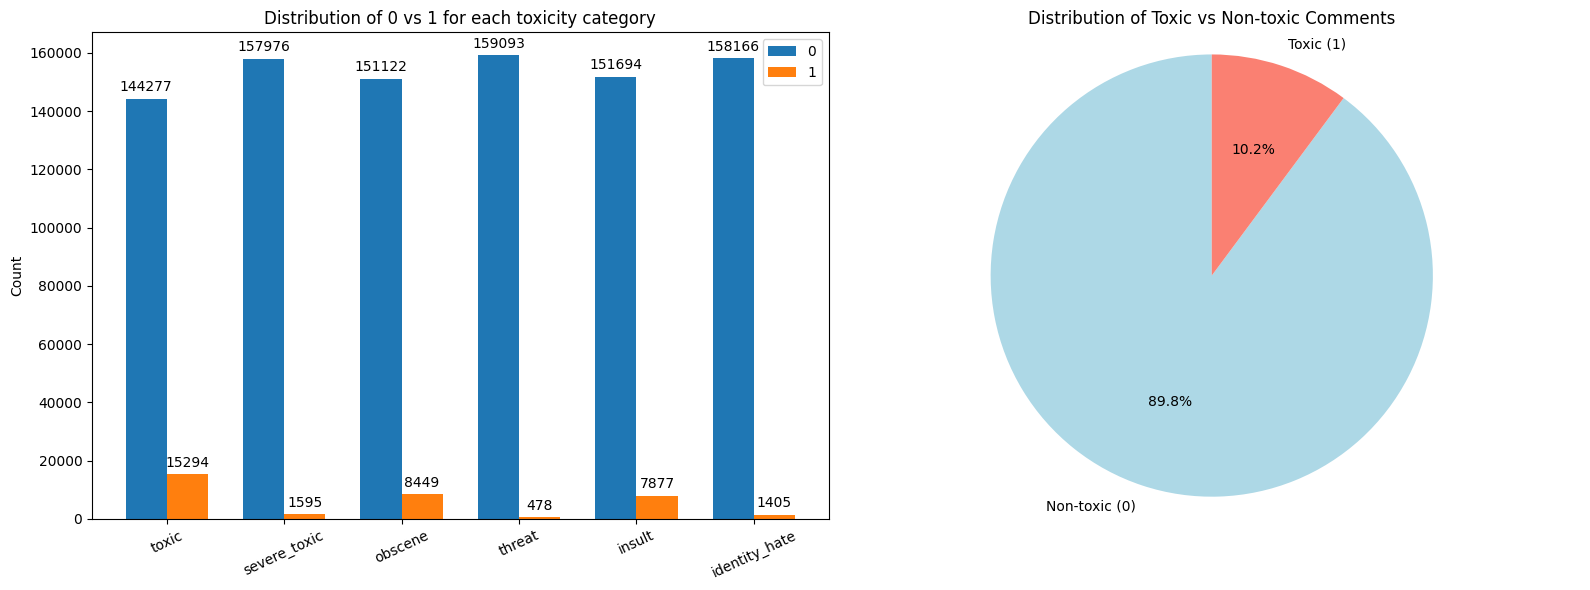

In [4]:
# Define the target label columns (as seen earlier)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Ensure they exist
label_cols = [c for c in label_cols if c in df.columns]

# Compute counts for 0 and 1 for each label
counts = []
for c in label_cols:
    vc = df[c].value_counts().to_dict()
    counts.append({'label': c, 'count_0': vc.get(0, 0), 'count_1': vc.get(1, 0)})
counts_df = pd.DataFrame(counts).set_index('label')

# Replace the custom function with standard display
print("Counts (0 vs 1) for each label")
display(counts_df)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot grouped bar chart on the left subplot
labels = counts_df.index.tolist()
count_0 = counts_df['count_0'].values
count_1 = counts_df['count_1'].values

x = np.arange(len(labels))
width = 0.35

# Bar chart on the left subplot
ax1.bar(x - width/2, count_0, width, label='0')
ax1.bar(x + width/2, count_1, width, label='1')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=25)
ax1.set_ylabel('Count')
ax1.set_title('Distribution of 0 vs 1 for each toxicity category')
ax1.legend()

# Annotate counts on top of bars
for i in range(len(x)):
    ax1.text(x[i] - width/2, count_0[i] + max(count_0)*0.01, str(int(count_0[i])), ha='center', va='bottom')
    ax1.text(x[i] + width/2, count_1[i] + max(count_0)*0.01, str(int(count_1[i])), ha='center', va='bottom')

# Add pie chart for detect_toxic column on the right subplot
if 'detect_toxic' in df.columns:
    # Get value counts for detect_toxic column
    toxic_counts = df['detect_toxic'].value_counts()
    
    # Create labels and values for the pie chart
    pie_labels = ['Non-toxic (0)', 'Toxic (1)']
    sizes = [toxic_counts.get(0, 0), toxic_counts.get(1, 0)]
    
    # Create pie chart on the right subplot
    ax2.pie(sizes, labels=pie_labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax2.set_title('Distribution of Toxic vs Non-toxic Comments')
    
    # Print the actual counts
    print(f"Non-toxic (0): {sizes[0]}")
    print(f"Toxic (1): {sizes[1]}")
else:
    ax2.text(0.5, 0.5, "Column 'detect_toxic' not found", ha='center', va='center')

plt.tight_layout()
plt.show()

# Pre Processing 

In this part I will try to clean my comment to get them ready for my model. 
First I will clean my text and then I will encode them 

## 1. Clean text

In [5]:
# I want to know the number of word in every comment to know the average
df["nb_mots"] = df["comment_text"].str.split().str.len()

# Average word
average_word = df['nb_mots'].mean()

# Dislpay
print('dataframe Shape :', df.shape)
print ('average word', average_word)
df.head()

dataframe Shape : (159571, 10)
average word 67.27352714465661


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,detect_toxic,nb_mots
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13


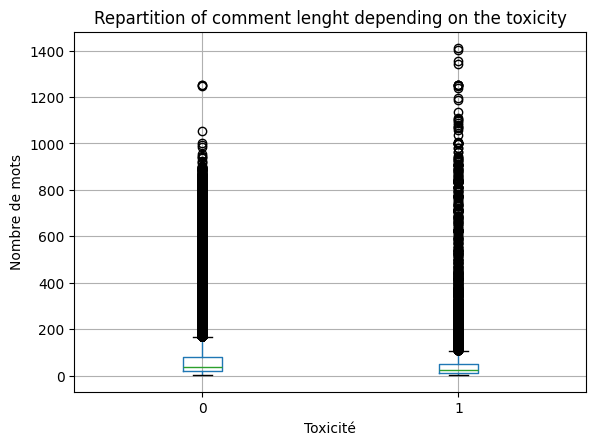

In [6]:
#test to check the relation between comment lenght and comment toxicity
df.boxplot(column="nb_mots", by="detect_toxic")
plt.title("Repartition of comment lenght depending on the toxicity")
plt.suptitle("")
plt.xlabel("Toxicité")
plt.ylabel("Nombre de mots")
plt.show()

In [7]:
# Pre-compiled regex patterns for performance
RE_URL = re.compile(r'https?://\S+|www\.\S+', flags=re.IGNORECASE)  # Detect URLs
RE_IP = re.compile(r'(([0-9]{1,3}\.){2,}[0-9]{1,3})')               # Detect IP addresses (basic IPv4 format)
RE_SYM_REPEAT = re.compile(r'([*!?.,;:()\[\]"\-—–])\1{2,}')         # Symbol repeated 3+ times
RE_LETTER_REPEAT = re.compile(r'([^\W\d_])\1{2,}', flags=re.UNICODE)  # Letter repeated 3+ times
RE_MULTI_SPACE = re.compile(r'\s{2,}')                              # Multiple spaces

def normalize_unicode(text):
    """
    Normalize unicode characters to a consistent representation (NFKC).
    This preserves accents while normalizing different forms of the same character.
    """
    return unicodedata.normalize('NFKC', text)

def clean_text_series(s: pd.Series,
                      lower: bool = True,
                      url_token: str = "[URL]",
                      ip_token: str = "[IP]",
                      max_letter_repeats: int = 2,
                      keep_sym_repeat_max: int = 3) -> pd.Series:
    """
    Clean a pandas Series of text efficiently using vectorized operations.

    Parameters:
    - lower: convert text to lowercase (disable for case-sensitive language models like BERT-base-cased)
    - url_token: token replacing detected URLs (keeps semantic value)
    - ip_token: token replacing detected IP addresses
    - max_letter_repeats: limit for character repetitions (e.g., "fuuuuck" → "fuuck" if set to 2)
    - keep_sym_repeat_max: limit for punctuation repetitions (e.g., "!!!!!" → "!!!")
    """

    s = s.astype(str).fillna("")   # Ensure text format + remove NaN
    s = s.map(normalize_unicode)   # Normalize unicode representation

    if lower:
        s = s.str.lower()

    # Replace URLs without adding extra whitespace
    s = s.str.replace(RE_URL, url_token, regex=True)

    # Replace IPs
    s = s.str.replace(RE_IP, ip_token, regex=True)

    # Remove newlines instead of replacing by token with spaces
    s = s.str.replace(r'\r\n|\r|\n', ' ', regex=True)

    # Reduce repeating punctuation marks
    def sym_repl(m):
        return m.group(1) * keep_sym_repeat_max
    s = s.str.replace(RE_SYM_REPEAT, lambda m: sym_repl(m), regex=True)

    # Reduce exaggerated letter repetitions
    if max_letter_repeats >= 1:
        def letter_repl(m):
            ch = m.group(1)
            return ch * max_letter_repeats
        s = s.str.replace(RE_LETTER_REPEAT, lambda m: letter_repl(m), regex=True)

    # Remove spacing rules around punctuation (no added spaces)
    
    # Replace emails with token
    s = s.str.replace(r'\b[\w\.-]+@[\w\.-]+\.\w{2,}\b', '[EMAIL]', regex=True)

    # Cleanup multiple spaces
    s = s.str.replace(RE_MULTI_SPACE, ' ', regex=True).str.strip()

    return s

In [8]:
# Create a small sample DataFrame to test the cleaning function
sample_data = {
    "comment_text": [
        "WTF!!!! This is soooo baaad... 😂😂😂 Check this out: https://example.com",
        "You are an IDIOT!!!!!!!",
        "Email me at test@example.com please!!!",
        "Fuuuuuuuck off!!! IP: 123.45.67.89",
        "Hello world :)",
        "No wayyyyyyy!!! WTF???",
        "Visit www.google.com now!!"
    ]
}

df_test = pd.DataFrame(sample_data)

df_test["clean_comment"] = clean_text_series(
    df_test["comment_text"],
    lower=True,
    url_token='[URL]',
    ip_token='[IP]',
    max_letter_repeats=2
)

df_test.head()

,comment_text,clean_comment
0,WTF!!!! This is soooo baaad... 😂😂😂 Check this ...,wtf!!! this is soo baad... 😂😂😂 check this out:...
1,You are an IDIOT!!!!!!!,you are an idiot!!!
2,Email me at test@example.com please!!!,email me at [EMAIL] please!!!
3,Fuuuuuuuck off!!! IP: 123.45.67.89,fuuck off!!! ip: [IP]
4,Hello world :),hello world :)


In [9]:
df_test['clean_comment'][0]

'wtf!!! this is soo baad... 😂😂😂 check this out: [URL]'

In [10]:
# Apply this to our dataset 
df["clean_comment"] = clean_text_series(
    df["comment_text"],
    lower=True,
    url_token='[URL]',
    ip_token='[IP]',
    max_letter_repeats=2
)

# I want to know the number of word aftrer clean the comment in every comment to know the average
df["nb_mots_clean"] = df["clean_comment"].str.split().str.len()

# Average word
average_word_cleaned = df['nb_mots_clean'].mean()

# Dislpay
print('dataframe Shape :', df.shape)
print ('average word', average_word_cleaned)
df.head()

dataframe Shape : (159571, 12)
average word 67.27745016325021


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,detect_toxic,nb_mots,clean_comment,nb_mots_clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,explanation why the edits made under my userna...,43
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,d'aww! he matches this background colour i'm s...,17
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,"hey man, i'm really not trying to edit war. it...",42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,""" more i can't make any real suggestions on im...",113
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,"you, sir, are my hero. any chance you remember...",13


In [11]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [12]:
df['clean_comment'][0]

"explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.[IP]"

## 2. Data Divide

In [13]:
# Get variable for texts and labels
texts = df['clean_comment'].astype(str).values
labels = df[df.columns[2:8]].values

In [14]:
# 1 = "good" (aucune catégorie présente), 0 = "has at least one toxic label"
is_good = (labels.sum(axis=1) == 0).astype(int)
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.15, stratify=is_good, random_state=SEED)

## 3. Encoding

In [15]:
# Text vectorization layer
# ---- Vectorization (Keras TextVectorization) ----
vectorize_layer = layers.TextVectorization(max_tokens=MAX_TOKENS, output_mode='int', output_sequence_length=SEQ_LEN)
vectorize_layer.adapt(X_train)
#vectorized_text = vectorize_layer(texts)

2025-11-12 03:46:26.768889: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-12 03:46:26.768949: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-12 03:46:26.768966: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-12 03:46:26.769002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-12 03:46:26.769042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 4. Model

In [47]:
count_0 = np.array([144277,157976,151122,159093,151694,158166])
count_1 = np.array([15294,1595,8449,478,7877,1405])
# pos_weight = negatives / positives
pos_weight = (count_0 / (count_1 + 1e-12)).astype(np.float32)
print("pos_weight:", pos_weight)

pos_weight: [  9.433569  99.04452   17.886377 332.83054   19.25784  112.57366 ]


pos_weight per label: {'toxic': 9.442296981811523, 'severe_toxic': 99.69413757324219, 'obscene': 17.8985652923584, 'threat': 333.07635498046875, 'insult': 19.277320861816406, 'identity_hate': 111.56016540527344}


/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_4' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 200)       │          0 │ text_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 200, 128)  │  2,560,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 200)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 200, 256)  │    263,168 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_4[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 6)         │        774 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,856,838 (10.90 MB)

 Trainable params: 2,856,838 (10.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 325s 153ms/step - auc: 0.8659 - loss: 3.9273 - val_auc: 0.9317 - val_loss: 2.5149 - learning_rate: 5.0000e-04
Epoch 2/6
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 303s 143ms/step - auc: 0.9326 - loss: 2.2968 - val_auc: 0.9260 - val_loss: 2.4849 - learning_rate: 5.0000e-04
Epoch 3/6
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 304s 143ms/step - auc: 0.9423 - loss: 2.0128 - val_auc: 0.9276 - val_loss: 2.6870 - learning_rate: 2.5000e-04


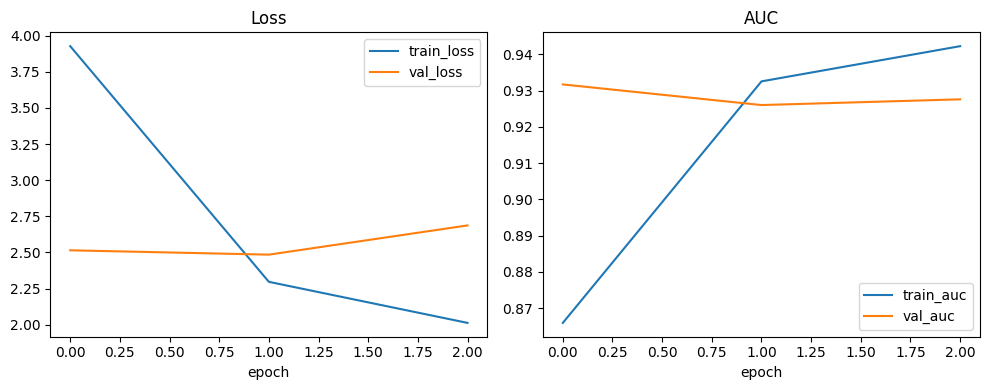

374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step
Best thresholds: {'toxic': 0.9123732447624207, 'severe_toxic': 0.9836545586585999, 'obscene': 0.959540605545044, 'threat': 0.9673439860343933, 'insult': 0.9496023058891296, 'identity_hate': 0.9886415600776672}

Per-label report (validation):
                precision    recall        f1   roc_auc  support
toxic           0.775585  0.733189  0.753791  0.964537   2305.0
severe_toxic    0.423676  0.548387  0.478032  0.986138    248.0
obscene         0.767494  0.801887  0.784314  0.983841   1272.0
threat          0.042440  0.444444  0.077482  0.942125     72.0
insult          0.677201  0.757576  0.715137  0.978582   1188.0
identity_hate   0.193732  0.340000  0.246824  0.957316    200.0

Micro F1: 0.6661   Macro F1: 0.5093


In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

# ----------------------------
# 1) Compute pos_weight from training labels
# ----------------------------
# y_train shape: (n_train, num_labels)
neg_counts = np.sum(y_train == 0, axis=0).astype(np.float32)
pos_counts = np.sum(y_train == 1, axis=0).astype(np.float32)
# avoid division by zero
pos_weight = (neg_counts / (pos_counts + 1e-12)).astype(np.float32)
print("pos_weight per label:", dict(zip(LABEL_COLS, map(float, pos_weight))))

# ----------------------------
# 2) Build model (logits output)
# ----------------------------
inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
x = vectorize_layer(inputs)
x = layers.Embedding(input_dim=MAX_TOKENS, output_dim=embedding_dim, mask_zero=True)(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
logits = layers.Dense(len(LABEL_COLS), activation=None, name="logits")(x)   # NOTE: logits, no sigmoid

model = keras.Model(inputs, logits)
model.summary()

# ----------------------------
# 3) Weighted loss using logits
# ----------------------------
pos_weight_tf = tf.constant(pos_weight, dtype=tf.float32)

def weighted_logits_loss(y_true, logits):
    # tf.nn.weighted_cross_entropy_with_logits returns per-label loss
    # we compute mean across labels for each sample then mean across batch
    loss_per_label = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=logits, pos_weight=pos_weight_tf)
    # shape (batch_size, num_labels) -> sum across labels then mean across batch
    return tf.reduce_mean(tf.reduce_sum(loss_per_label, axis=-1))

# compile (AUC metric is OK even with logits because AUC is order-invariant)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss=weighted_logits_loss,
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# ----------------------------
# 4) tf.data pipelines
# ----------------------------
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(20000, seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# 5) Callbacks and training
# ----------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# ----------------------------
# 6) Plots Loss / AUC
# ----------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss'); plt.xlabel('epoch')

plt.subplot(1,2,2)
if 'auc' in history.history:
    plt.plot(history.history['auc'], label='train_auc')
if 'val_auc' in history.history:
    plt.plot(history.history['val_auc'], label='val_auc')
plt.legend(); plt.title('AUC'); plt.xlabel('epoch')

plt.tight_layout()
plt.show()

# ----------------------------
# 7) Predict probs on validation (apply sigmoid to logits)
# ----------------------------
logits_val = model.predict(X_val, batch_size=BATCH)   # shape (n_val, num_labels)
probs_val = tf.nn.sigmoid(logits_val).numpy()

# ----------------------------
# 8) Find best threshold per label (max F1 on val)
# ----------------------------
best_thresholds = {}
for i, lab in enumerate(LABEL_COLS):
    ytrue = y_val[:, i]
    yprob = probs_val[:, i]
    if ytrue.sum() == 0:
        best_thresholds[lab] = 0.5
        continue
    prec, rec, thr = precision_recall_curve(ytrue, yprob)
    if thr.size == 0:
        best_thresholds[lab] = 0.5
    else:
        f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
        best_thresholds[lab] = float(thr[np.argmax(f1s)])
print("Best thresholds:", best_thresholds)

# ----------------------------
# 9) Evaluate on validation using these thresholds
# ----------------------------
pred_bin_val = np.zeros_like(probs_val, dtype=int)
for i, lab in enumerate(LABEL_COLS):
    t = best_thresholds.get(lab, 0.5)
    pred_bin_val[:, i] = (probs_val[:, i] >= t).astype(int)

# per-label metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
report = {}
for i, lab in enumerate(LABEL_COLS):
    ytrue = y_val[:, i]
    ypred = pred_bin_val[:, i]
    report[lab] = {
        "precision": precision_score(ytrue, ypred, zero_division=0),
        "recall": recall_score(ytrue, ypred, zero_division=0),
        "f1": f1_score(ytrue, ypred, zero_division=0),
        "roc_auc": roc_auc_score(ytrue, probs_val[:, i]) if ytrue.sum()>0 else None,
        "support": int(ytrue.sum())
    }

report_df = pd.DataFrame(report).T
print("\nPer-label report (validation):\n", report_df)

# micro/macro f1
micro_f1 = f1_score(y_val, pred_bin_val, average='micro', zero_division=0)
macro_f1 = f1_score(y_val, pred_bin_val, average='macro', zero_division=0)
print(f"\nMicro F1: {micro_f1:.4f}   Macro F1: {macro_f1:.4f}")

# ----------------------------
# 10) Save model and thresholds for inference
# ----------------------------
# Save Keras model (weights + architecture); note: model outputs logits
model.save("multilabel_model_with_posweight.keras")


/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_2' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 200)       │          0 │ input_layer_2[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 200, 128)  │  2,560,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 200)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 200, 256)  │    263,168 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_2[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 6)         │        774 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,856,838 (10.90 MB)

 Trainable params: 2,856,838 (10.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 361s 170ms/step - auc: 0.9379 - loss: 0.0838 - val_auc: 0.9751 - val_loss: 0.0584
Epoch 2/6
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 356s 168ms/step - auc: 0.9733 - loss: 0.0569 - val_auc: 0.9776 - val_loss: 0.0527
Epoch 3/6
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 357s 168ms/step - auc: 0.9797 - loss: 0.0504 - val_auc: 0.9752 - val_loss: 0.0547
Epoch 4/6
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 365s 172ms/step - auc: 0.9836 - loss: 0.0473 - val_auc: 0.9746 - val_loss: 0.0517
Epoch 5/6
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 366s 172ms/step - auc: 0.9855 - loss: 0.0450 - val_auc: 0.9661 - val_loss: 0.0533
Epoch 6/6
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 368s 174ms/step - auc: 0.9870 - loss: 0.0438 - val_auc: 0.9691 - val_loss: 0.0534
374/374 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step


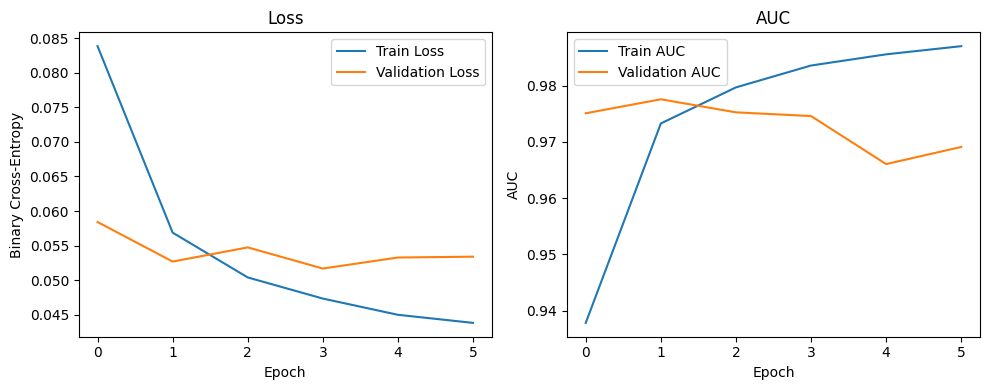

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve


# ---- Build multi-label model ----
inputs = layers.Input(shape=(), dtype=tf.string)  # shape () = scalar string
x = vectorize_layer(inputs)                        # output: (batch_size, seq_len)
x = layers.Embedding(input_dim=MAX_TOKENS, output_dim=embedding_dim, mask_zero=True)(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(LABEL_COLS), activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
model.summary()

# ---- tf.data pipeline ----
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(20000, seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# ---- Callbacks ----
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=1)
]

# ---- Train ----
#history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# ---- Predict probabilities on validation ----
probs_val = model.predict(X_val, batch_size=BATCH)  # shape (n_val, num_labels)

plt.figure(figsize=(10, 4))

# --- Courbe de la loss ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy')

# --- Courbe de l’AUC ---
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend()
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.tight_layout()
plt.show()

## 5. Evaluation

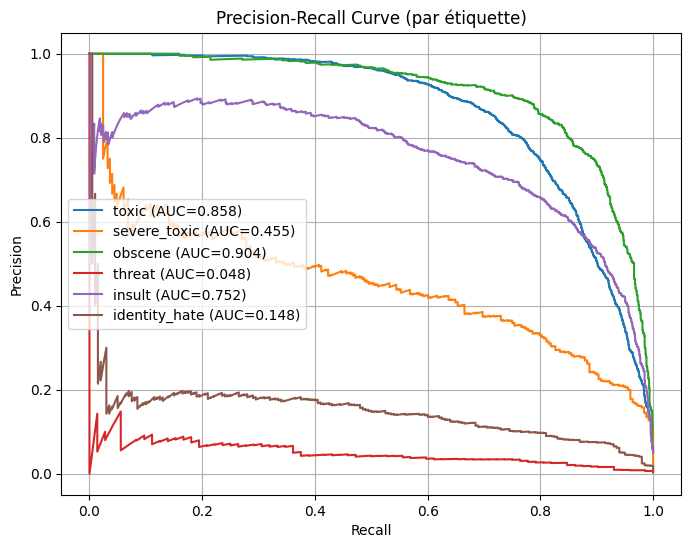

In [38]:
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(8,6))
for i, label in enumerate(LABEL_COLS):
    precision, recall, _ = precision_recall_curve(y_val[:, i], probs_val[:, i])
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, label=f"{label} (AUC={auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (par étiquette)")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# --- Choose threshold ---
threshold = 0.5
y_pred_bin = (probs_val > threshold).astype(int)

# --- Global metrics ---
f1_micro = f1_score(y_val, y_pred_bin, average='micro')
f1_macro = f1_score(y_val, y_pred_bin, average='macro')
precision_micro = precision_score(y_val, y_pred_bin, average='micro')
recall_micro = recall_score(y_val, y_pred_bin, average='micro')

print(f"🔹 Threshold: {threshold}")
print(f"Micro F1: {f1_micro:.4f}")
print(f"Macro F1: {f1_macro:.4f}")
print(f"Micro Precision: {precision_micro:.4f}")
print(f"Micro Recall: {recall_micro:.4f}")

report = classification_report(y_val, y_pred_bin, target_names=LABEL_COLS)
print(report)

🔹 Threshold: 0.5
Micro F1: 0.7235
Macro F1: 0.4484
Micro Precision: 0.8179
Micro Recall: 0.6486
               precision    recall  f1-score   support

        toxic       0.81      0.75      0.78      2305
 severe_toxic       0.50      0.41      0.45       248
      obscene       0.89      0.77      0.83      1272
       threat       0.00      0.00      0.00        72
       insult       0.82      0.52      0.64      1188
identity_hate       0.00      0.00      0.00       200

    micro avg       0.82      0.65      0.72      5285
    macro avg       0.50      0.41      0.45      5285
 weighted avg       0.78      0.65      0.70      5285
  samples avg       0.07      0.06      0.06      5285



/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0

In [40]:
# Save model
model_save_path = "multilabel_text_classifier.keras"
model.save(model_save_path, include_optimizer=False)
print("Model saved to:", model_save_path)

Model saved to: multilabel_text_classifier.keras


## 6. Test

In [50]:
test_texts = [
    # ✅ GOOD / NON-TOXIC
    "Thank you for your feedback, I’ll make sure to improve next time!",
    "That’s an interesting point, I appreciate your perspective.",
    "You did a great job leading this project, well deserved!",
    "I really enjoy collaborating with you, you always bring good energy!",
    "This discussion is very productive, thanks everyone!",
    
    # ⚠️ TOXIC (general aggression)
    "You’re so annoying, just stop talking already.",
    "What a terrible post, you have no idea what you're saying.",
    "Nobody asked for your opinion.",
    
    # ❗ SEVERE TOXIC
    "You are such a worthless human being.",
    "I hope you fail miserably at everything you do.",
    "Go away and never come back, loser.",
    
    # 💀 THREAT
    "If you touch my stuff again, I’ll make you regret it.",
    "Watch your back, I know where you live.",
    "You better pray I don’t find you.",
    
    # 🤬 OBSCENE
    "This is such a f***ing mess, I can’t believe it.",
    "Get your s*** together already.",
    "Stop acting like a damn fool.",
    
    # 😡 INSULT
    "You’re such an idiot, seriously.",
    "Only a moron would think that’s a good idea.",
    "You can’t even do one simple thing right.",
    
    # 🧩 IDENTITY ATTACK
    "People like you don’t belong here.",
    "You’re just another dumb kid from that country.",
    "I can’t stand people from your background.",
    
    # 💬 MIXED CASES
    "That was an awful presentation, but I know you tried your best.",
    "This idea sucks, but the effort is appreciated.",
    "You’re wrong, but I’ll help you fix it.",
]

# Convert list of strings to a TensorFlow tensor
test_tensor = tf.convert_to_tensor(test_texts, dtype=tf.string)

# Predict
probs = model.predict(test_tensor, batch_size=32)

# Convert probabilities to binary labels
preds = (probs > 0.3).astype(int)

# Build results DataFrame
results = pd.DataFrame(probs, columns=LABEL_COLS)
results.insert(0, "text", test_texts)
results["good_message"] = (preds.sum(axis=1) == 0).astype(int)

pd.set_option('display.max_colwidth', None)
results.head(20)

/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_4' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


,text,toxic,severe_toxic,obscene,threat,insult,identity_hate,good_message
0,"Thank you for your feedback, I’ll make sure to improve next time!",-2.015975,-4.695349,-3.276778,-3.017577,-2.903025,-2.967428,1
1,"That’s an interesting point, I appreciate your perspective.",-2.263360,-4.784391,-3.528059,-3.131151,-3.048595,-3.062616,1
2,"You did a great job leading this project, well deserved!",-1.145383,-3.484683,-2.352096,-1.917878,-1.973181,-1.977465,1
3,"I really enjoy collaborating with you, you always bring good energy!",-0.017617,-2.048908,-0.982576,-0.957473,-0.869254,-0.983855,1
4,"This discussion is very productive, thanks everyone!",-2.231700,-4.565186,-3.459106,-2.822705,-2.975625,-2.862640,1
5,"You’re so annoying, just stop talking already.",-0.365337,-2.290253,-1.368587,-1.095593,-1.117246,-1.071262,1
6,"What a terrible post, you have no idea what you're saying.",-0.649735,-2.655883,-1.643194,-1.394193,-1.445875,-1.376880,1
7,Nobody asked for your opinion.,-1.157832,-2.907230,-2.077305,-1.674880,-1.826150,-1.636722,1
8,You are such a worthless human being.,4.134104,1.300734,3.028355,2.476574,2.825771,2.384642,0
9,I hope you fail miserably at everything you do.,-0.056652,-2.080765,-1.065832,-0.871474,-0.895110,-0.877148,1


In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf

# test texts (as you already have)
test_texts = [
    "Thank you for your feedback, I’ll make sure to improve next time!",
    "That’s an interesting point, I appreciate your perspective.",
    "You did a great job leading this project, well deserved!",
    "I really enjoy collaborating with you, you always bring good energy!",
    "This discussion is very productive, thanks everyone!",
    "You’re so annoying, just stop talking already.",
    "What a terrible post, you have no idea what you're saying.",
    "Nobody asked for your opinion.",
    "You are such a worthless human being.",
    "I hope you fail miserably at everything you do.",
    "Go away and never come back, loser.",
    "If you touch my stuff again, I’ll make you regret it.",
    "Watch your back, I know where you live.",
    "You better pray I don’t find you.",
    "This is such a f***ing mess, I can’t believe it.",
    "Get your s*** together already.",
    "Stop acting like a damn fool.",
    "You’re such an idiot, seriously.",
    "Only a moron would think that’s a good idea.",
    "You can’t even do one simple thing right.",
    "People like you don’t belong here.",
    "You’re just another dumb kid from that country.",
    "I can’t stand people from your background.",
    "That was an awful presentation, but I know you tried your best.",
    "This idea sucks, but the effort is appreciated.",
    "You’re wrong, but I’ll help you fix it.",
]

# Make sure input shape/dtype matches model expectation
# Two safe options: tf.constant(strings, dtype=tf.string) OR numpy array with dtype=object
inputs_for_predict = tf.constant(test_texts, dtype=tf.string)
# Or: inputs_for_predict = np.array(test_texts, dtype=object)

# -------------- Predict probabilities --------------
probs = model.predict(inputs_for_predict, batch_size=32)   # shape (n_samples, n_labels)

# -------------- Thresholding --------------
# Option A: single global threshold
global_threshold = 0.3
pred_bin = (probs >= global_threshold).astype(int)

# Option B (recommended if you computed optimal thresholds per label):
# best_thresholds = {'toxic':0.45,...}  # example dict
# pred_bin = np.zeros_like(probs, dtype=int)
# for i, lab in enumerate(LABEL_COLS):
#     t = best_thresholds.get(lab, 0.5)
#     pred_bin[:, i] = (probs[:, i] >= t).astype(int)

# -------------- good_message logic (CORRECT) --------------
# good_message = 1 if and only if no label is activated (all zeros)
good_message = (pred_bin.sum(axis=1) == 0).astype(int)

# -------------- Build readable DataFrame --------------
df_res = pd.DataFrame(probs, columns=[f"prob_{c}" for c in LABEL_COLS])
for i, c in enumerate(LABEL_COLS):
    df_res[f"pred_{c}"] = pred_bin[:, i]
df_res["good_message"] = good_message
df_res.insert(0, "text", test_texts)

# Also add a human-friendly "predicted_labels" column
def labels_from_row(row):
    active = [LABEL_COLS[i] for i in range(len(LABEL_COLS)) if row[f"pred_{LABEL_COLS[i]}"] == 1]
    return active if len(active) > 0 else ["good"]

df_res["predicted_labels"] = df_res.apply(labels_from_row, axis=1)

pd.set_option('display.max_colwidth', 200)
print(df_res[["text", "predicted_labels", "good_message"]].to_string(index=False))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
                                                                text                                              predicted_labels  good_message
   Thank you for your feedback, I’ll make sure to improve next time!                                                        [good]             1
         That’s an interesting point, I appreciate your perspective.                                                        [good]             1
            You did a great job leading this project, well deserved!                                                        [good]             1
I really enjoy collaborating with you, you always bring good energy!                                                        [good]             1
                This discussion is very productive, thanks everyone!                                                        [good]             1
                      You’re so annoying, just stop talking already.                        

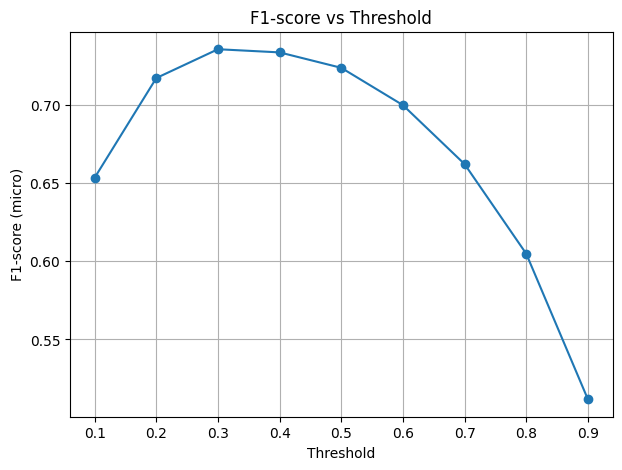

✅ Best threshold: 0.30 with F1=0.7354


In [44]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.linspace(0.1, 0.9, 9)
f1_scores = []

for t in thresholds:
    preds_t = (probs_val > t).astype(int)
    f1 = f1_score(y_val, preds_t, average='micro')
    f1_scores.append(f1)

plt.figure(figsize=(7,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.title("F1-score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score (micro)")
plt.grid(True)
plt.show()

best_t = thresholds[np.argmax(f1_scores)]
print(f"✅ Best threshold: {best_t:.2f} with F1={max(f1_scores):.4f}")

In [25]:
# Show a few predictions
samples = ["hey i freaken hate you!"]
preds = model.predict(tf.constant(samples, dtype=tf.string))
print(preds)
for s,p in zip(samples,preds):
    print(f"{s[:60]:60} -> {p[0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
[[0.9783594]]
hey i freaken hate you!                                      -> 0.9784


In [26]:
def score_comment(comment):
    # Crée un batch d'une seule phrase
    sample = [comment]
    
    # Prédiction avec le modèle
    results = model.predict(tf.constant(sample, dtype=tf.string))
    
    # On prend le premier résultat et le premier score (si c'est un modèle binaire)
    score = results[0][0]
    
    return f"{score:.4f}"

In [27]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text',
                        flagging_mode="never")

In [28]:
interface.launch(share=True, inline=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d0d1b66b63e90b0e5d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
